# Game Theory Project - Mapinator Simulation

ECON 514

David Weaver

In [27]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import os
from scipy.stats import truncnorm
from typing import Dict, List

## Designing Truncated Normal Distribution

In [28]:
# DEFINE A TRUNCATED NORMAL DISTRIBUTION

def truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# DEFINE A TRUNCATED NORMAL CDF

def truncated_normal_cdf(x, mean, sd, low, upp):
    return truncnorm.cdf(
        x, (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# DEFINE A TRUNCATED NORMAL PDF

def truncated_normal_pdf(x, mean, sd, low, upp):
    return truncnorm.pdf(
        x, (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# DEFINE AN INVERSE TRUNCNORM CDF

def inverse_truncnorm_cdf(fx, mean, sd, low, upp):
    return truncnorm.ppf(
        fx, (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

## Example: Truncated Normal Functions:

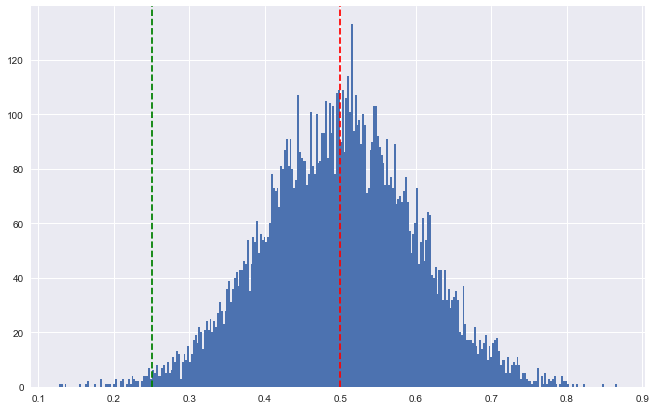

F(x=0.5)= 0.5000000000000001
F(x=0.25)= 0.006209382234062609
x = F^(-1)(0.5)= 0.5
x = F^(-1)(0.006209382234062609)= 0.25


In [29]:
# Generate Random Values
X = truncated_normal(mean=0.5, sd=0.1, low=0, upp=1)

# Plot Histogram
np.random.seed(1)
fig, ax = plt.subplots(figsize=(11,7))
ax.hist(X.rvs(10000), 300)
plt.axvline(x=0.5, color="red", linestyle="--")
plt.axvline(x=0.25, color="green", linestyle="--")
plt.show()

# Practice with CDF: Get CDF of x = 0.5
prob5 = truncated_normal_cdf(x=0.5,mean=0.5, sd=0.1, low=0, upp=1)
print("F(x=0.5)=",prob5)

# Practice with CDF: Get CDF of x = 0.5
prob25 = truncated_normal_cdf(x=0.25,mean=0.5, sd=0.1, low=0, upp=1)
print("F(x=0.25)=",prob25)

# Test Inverse CDF Get x given CDF = 0.5
x5 = inverse_truncnorm_cdf(fx=0.5,mean=0.5, sd=0.1, low=0, upp=1)
print("x = F^(-1)(0.5)=", x5)

# Test Inverse CDF Get x given CDF = 0.006209382234062609
x25 = inverse_truncnorm_cdf(fx=0.006209382234062609,mean=0.5, sd=0.1, low=0, upp=1)
print("x = F^(-1)(0.006209382234062609)=", x25)

# $N \times M$ Model


### Simulation Specifications:

##### 1. N Universities $\{U_1, U_2, ... , U_i, ... U_N\}$ , M Graduates $\{v_1, v_2, ... , v_j, ... v_M\}$, where $v_j$ denotes the value of graduate j.

Each graduate is randomly assigned as "graduating" from a university of the same tier. Drawn from a uniform distribution.

##### 2. Four Tiers of Universities and Graduates. All graduates of tier $t$ have same value $v_t$ 

##### 3. Universities are assigned tiers by probability. There are more Tier4 than Tier3 Universities, and so forth.

Researcher specifies the probability a university/graduate is of any tier. Then, universities and graduates are generated using these probabilities. All done with a uniform distribution for computational simplicity.

##### 4. University offers $t$ are drawn from a truncated normal distribution

Mean and standard deviation for each tier are specified by researcher.

Only one offer per unviersity.

##### 5. Highest offer wins the candidate.

##### 6. All candidates that are not matched in the academic circle are entered into the "non-academic" sink.

##### 7. Tier Adjacency Matrix and university Adjacency Matrix are generated for each round. 

For repeated games, the new hires are added to the existing adjacency matrix.

##### 8. Solve for offer cutoffs as follows:

An offer cutoff $x_t$ is the offer such that a university that draws this offer is indifferent between hiring a guaranteed $x_{t+1}$ candidate, and applying to a tier $x_t$ candidate. A university with an offer above this cutoff will never apply to a tier ranked lower than the cutoff's associated tier (i.e. if $x \geq x_{t}$, the university will never offer to an applicant of a tier ranked lower (ex. $x_{t+1}$) 

This implies indifference between the guaranteed payoff of the $t+1$ candidate and the expected payoff of the $t$ candidate.

i.e:

$$ \underbrace{v_{t+1}}_{\text{Payoff of Offering Tier}~ t+1} = 
\underbrace{v_t \left( 1 - \int_x^{x_{t -1}} \frac{\pi(\tilde{x}) dF(\tilde{x})}{m_t}\right)^{n-1}}_{\text{E(Payoff) of Offering Tier} ~t}$$

Here, $v_{t+1}$ represents the guaranteed payoff of applying to a tier $t+1$ candidate, and $v_t$ is the payoff of hiring a tier $t$ graduate. 

The probability that one of your competitors beats you for the same graduate is:

$$ \left( 1 - \int_x^{x_{t -1}} \frac{\pi(\tilde{x}) dF(\tilde{x})}{m_t}\right)^{n-1} $$

where $x_{t-1}$ is the cutoff of a higher tier, and $x$ is your drawn offer. If a competing university has a drawn offer greater than $x_{t-1}$, they will never apply to the tier $t$ university, so we only need to worry about offers greater than $x$ and less than $x_{t-1}$ when applying to some tier $t$. These are all the offers that, if delivered to the same candidate, would beat out our hypothetical university.

The other componenets of this probability are $m_t$, the number of applicants in that tier, $\pi_t(\tilde{x})$, the probability that a candidate with some drawn offer from random variable $x$ offers to a tier $t$ candidate. Finally, tier $F(\tilde{x})$ is the distribution of the offers drawn from a truncated normal (as specified by the researcher). The equation is raised to the power $n-1$ to represent the fact that $n-1$ competitors must not apply to the same candidate with a higher offer.

By simple evaluation, we can rewrite the indifference condition as:

$$ \underbrace{v_{t+1}}_{\text{Payoff of Offering Tier}~ t+1} = 
\underbrace{v_t \left(1 - \frac{\pi_t( F(x_{t-1}) -F(x))}{m_t}\right)^{n-1}}_{\text{E(Payoff) of Offering Tier} ~t}$$

To solve for $x_{t-1}$, we solve the following:

$$ F(x_t) = F(x_{t-1}) - \frac{m_t}{\pi_t}\left(1-\left(\frac{v_{t+1}}{v_t}\right)^{\frac{1}{n-1}}\right) $$

We can solve recursively by beginning with the top tier:

1. Tier 1:

Since Tier 1 is the highest tier, there is no cutoff above it. The ceiling of offers in a truncated normal is whatever the researcher bounds the cutoff to be. Therefore, using the upper bound, evaluating the CDF is trivial:

$$ F(x_0) = 1 $$ 

Thus, we can solve for the cutoff $(x_t)$ when $t=1$ as follows:

$$ F(x_1) = 1 - \frac{m_1}{\pi_1}\left(1-\left(\frac{v_{2}}{v_1}\right)^{\frac{1}{n-1}}\right) $$

$$ x_1 = F^{-1} \left(1 - \frac{m_1}{\pi_1}\left(1-\left(\frac{v_{2}}{v_1}\right)^{\frac{1}{n-1}}\right) \right) $$

All other cutoffs can be solved recursively, now that we have $x_1$ and $F(x_1)$:

$$ x_2 = F^{-1} \left(F(x_1) - \frac{m_2}{\pi_2}\left(1-\left(\frac{v_{3}}{v_2}\right)^{\frac{1}{n-1}}\right) \right) $$

$$ x_3 = F^{-1} \left(F(x_2) - \frac{m_3}{\pi_3}\left(1-\left(\frac{v_{4}}{v_3}\right)^{\frac{1}{n-1}}\right) \right) $$

however, since there is no lower tier than 4, we trivially assign the cutoff as 0:

$$ x_4 = 0 $$


The truncated normal distribution $F()$ is estimated by MLE. The guess used for the MLE is a weighted average of all tier parameter characteristics.

An alternative approach to solving for $F$ is to simply sum the CDFs. This method was initially used, but solving the inverse of this function was proving to be difficult. Instead, I attempted to solve for the cutoffs using root finding (ex. Solve for $x_1$ in $ F(x_1) = 1 - \frac{m_1}{\pi_1}\left(1-\left(\frac{v_{2}}{v_1}\right)^{\frac{1}{n-1}}\right) $ with Bisection, Newton's Method, and the Scipy feature FSolve(). None of these methods converged to the correct solution, and therefore, I use MLE to obtain $F()$ in the simulation, despite this being different theoretical approach.

To solve for each $\pi_t$, we can begin with $\pi_1$.

All else can be calculated recursively:


$$ \pi_1 = 1  $$

$$ \pi_2 = \frac{\pi_1}{\pi_1 +(\frac{v_2}{v_{1}})^{\frac{1}{n-1}}(\frac{m_{1}}{m_2})} = \frac{1}{1 +(\frac{v_2}{v_{1}})^{\frac{1}{n-1}}(\frac{m_{1}}{m_2})} $$

$$ \pi_3 = \frac{\pi_2}{\pi_2+(\frac{v_3}{v_{2}})^{\frac{1}{n-1}}(\frac{m_{2}}{m_3})} $$

$$ \pi_4 = \frac{\pi_3}{\pi_3+(\frac{v_4}{v_{3}})^{\frac{1}{n-1}}(\frac{m_{3}}{m_4})} $$

##### 9. Probabilty of a tier $s$ university applying to a tier $t$ graduate is determined as follows:

In part 8, our solutions for the cutoffs required the probabilities $\pi_t$, i.e. the probability that a university will apply to a tier $t$ applicant.

These probabilities can also be solved recursively, and reduced to constants. This allows for the cutoffs to also be made constants.

Corollary 2: Strategy profiles:

Probability of a university with offer $x$ applying to a tier $j$ applicant:


$$ \tilde{\pi_j}(x) = 
\begin{cases} 
        \underbrace{\frac{\pi_{j-1}}{\pi_{j-1}+(\frac{v_j}{v_{j-1}})^{\frac{1}{n-1}}(\frac{m_{j-1}}{m_j})}}_{\pi_j} \prod_{j<i \leq t} 
        \underbrace{\left(1 - \frac{\pi_{i-1}}{\pi_{i-1}+(\frac{v_i}{v_{i-1}})^{\frac{1}{n-1}} (\frac{m_{i-1}}{m_i})}\right)}_{1-\pi_i} & j \leq t \\
        0 & otherwise \\
\end{cases} $$


where:

$m_j$ is the number of applicants in tier $j$

$v_j$ is the value of a tier $j$ applicant

$n$ is the number of universities competing for applicants.

$t$ is the tier of the cutoff point for a given draw. For example, if a draw $x \in [x3,x2)$, then the lowest cutoff point is $x3$; Thus, in corrolary 2, the subscript $t$ would denote $t=3$


The second term following the Product $\Pi$ is simply $1-\pi_i$, where $i>j$ 


##### 10. Probability of a university with offer $s$ applying to a tier $t$ graduate is as follows:

   (a) Suppose a university draws some offer $x \geq x_1$:

The university will apply to a tier 1 university with probability 1.

$$ \tilde{\pi_1}(x) = 1 $$

   (b) Suppose a university draws some offer $x_2 \leq x \leq x_1$

The university will offer to either to tier 2 at a probability of:

$$ \tilde{\pi_2}(x) = \pi_2 \\ = \frac{\pi_1}{\pi_1 +(\frac{v_2}{v_{1}})^{\frac{1}{n-1}}(\frac{m_{1}}{m_2})} \\ = \frac{1}{1 +(\frac{v_2}{v_{1}})^{\frac{1}{n-1}}(\frac{m_{1}}{m_2})} $$

Or tier 1 at a probability of:

$$ \tilde{\pi_1}(x) = \pi_1(1 - \pi_2) \\ =  (1 - \pi_2)$$

   (c) Suppose a university draws some offer $x_3 \leq x \leq x_2$

The university will offer to either to tier 3 at a probability of:

$$ \tilde{\pi_3}(x) = \pi_3 = \frac{\pi_2}{\pi_2+(\frac{v_3}{v_{2}})^{\frac{1}{n-1}}(\frac{m_{2}}{m_3})}$$

Or tier 2 at a probability of:

$$ \tilde{\pi_2}(x) = \pi_2 (1 - \pi_3)$$

Or tier 1 at a probability of:

$$ \tilde{\pi_1}(x) = \pi_1 (1-\pi_2) (1 - \pi_3) \\ = (1-\pi_2) (1 - \pi_3) $$

   (d) Suppose a university draws some offer $x_4 \leq x \leq x_3$

The university will offer to either tier 4 at a probability of:

$$ \tilde{\pi_4}(x) = \pi_4 = \frac{\pi_3}{\pi_3+(\frac{v_4}{v_{3}})^{\frac{1}{n-1}}(\frac{m_{3}}{m_4})}$$

The university will offer to either to tier 3 at a probability of:

$$ \tilde{\pi_3}(x) = \pi_3 (1-\pi_4) $$

Or tier 2 at a probability of:

$$ \tilde{\pi_2}(x) =  \pi_2(1-\pi_3) (1-\pi_4)$$

Or tier 1 at a probability of:

$$ \tilde{\pi_1}(x) =  \pi_1 (1-\pi_2) (1-\pi_3) (1-\pi_4) \\ = (1-\pi_2) (1-\pi_3) (1-\pi_4)$$


##### 11. Probability of applying to a  graduate given a university has already picked what tier to apply is uniformly distirbuted. 

## ----------- Helper Functions ------------

In [30]:
def generate_agents(universities:int, graduates:float, tier_probs:str):
    
    """
    Takes: number of graduates and universities in the model.
    
    Takes: probability any given university is of a tier
    ex. tier_probs = [prob(tier1), prob(tier2), prob(tier3), prob(tier4)] = [0.1, 0.2, 0.3, 0.4]
    
    Returns the following:
    
    1. number of universities from each tier (list)
    2. number of graduates from each tier (list)
    
    Where the first number in the list is the number of tier1, second is number of tier2, etc...
    
    """
    if float(sum(tier_probs)) != 1 or len(tier_probs) != 4:
        return "Probabilities must sum to 1 and there must be 4 tiers. Please return a valid `tiers_prob`"
    
    t1unis, t2unis, t3unis, t4unis = 0,0,0,0
    t1grads, t2grads, t3grads, t4grads = 0,0,0,0
    
    tierlist = ["tier1", "tier2", "tier3", "tier4"]
    
    for uni_ in range(universities):
        draw = np.random.choice(tierlist,p=tier_probs)
        if draw == "tier1":
            t1unis += 1
        elif draw == "tier2":
            t2unis += 1
        elif draw == "tier3":
            t3unis += 1
        else:
            t4unis += 1
    
    for grad_ in range(graduates):
        draw = np.random.choice(tierlist,p=tier_probs)
        if draw == "tier1":
            t1grads += 1
        elif draw == "tier2":
            t2grads += 1
        elif draw == "tier3":
            t3grads += 1
        else:
            t4grads += 1
    
    university_types = [t1unis, t2unis, t3unis, t4unis]
    graduate_types = [t1grads, t2grads, t3grads, t4grads]
    
    if 0 in university_types:
        university_types = "retry"
    
    return university_types, graduate_types

    

In [31]:
def graduated_from(grad_dict:dict, uni_dict:dict):
    """
    
    Takes a dictionary of graduates and respective Tiers / Offers: (grad_dict)
    
    ex. {'tier1': {'v1': 1, 'v2': 1, 'v3': 1, 'v4': 1, 'v5': 1}, 
    'tier2': {'v6': 0.8, 'v7': 0.8, 'v8': 0.8, 'v9': 0.8, 'v10': 0.8, 'v11': 0.8}, 
    'tier3': {'v12': 0.6, 'v13': 0.6, 'v14': 0.6, 'v15': 0.6, 'v16': 0.6, 'v17': 0.6}, 
    'tier4': {'v18': 0.4, 'v19': 0.4, 'v20': 0.4, 'v21': 0.4, 'v22': 0.4, 'v23': 0.4, 'v24': 0.4, 'v25': 0.4, 'v26': 0.4, 'v27': 0.4, 'v28': 0.4, 'v29': 0.4, 'v30': 0.4}} 
    
    Takes a dictionary of universities and respective Tiers: (uni_dict)

    ex. {'tier1': ['U1'], 'tier2': ['U2', 'U3'], 'tier3': ['U4', 'U5', 'U6', 'U7'], 'tier4': ['U8', 'U9', 'U10']} 
    
    Returns a dictionary of all graduates as key, and university they came from as definition
    
    Each university is said to have "graduated" those students.
    Graduates are randomly matched (uniform) to a uni of the same tier.
    
    """
    graduated_from = {}

    for tier in grad_dict.keys():
        applicants = grad_dict[tier]
        for indv in applicants.keys():
            indv_from = np.random.choice(uni_dict[tier])
            graduated_from[indv] = indv_from

    return graduated_from
    
    

In [32]:
def add_sink_placements(academic_matches:dict, graduates_from:dict):
    
    """
    Takes the final list of matches
    
    Finds all unmatched candidates
    
    Matches them to "Non-Academic" as a category.
    
    Returns new set of matches excluding unis that didn't hire a grad,
    but including a non-academic "sink" for all unmatched grads.
    
    """
    sink = []
    grads_matched_to_uni = []
    
    for uni in academic_matches.copy().keys():
        matched_grad = academic_matches[uni][0]
        if matched_grad != "Lost Bid":
            grads_matched_to_uni.append(matched_grad)
        elif matched_grad == "Lost Bid":
            del academic_matches[uni]
    
    for grad in graduates_from.keys():
        if grad not in grads_matched_to_uni:
            sink.append(grad)
            
    complete_matches = academic_matches
    complete_matches["Non-Academic"] = sink
            
    return complete_matches
    
    

In [33]:
def adjacency_matrix(matches_with_sinks:dict, graduates_from:dict, unis_by_tier:dict, uni_and_tier:bool, uni_offers:dict):
    
    """
    Given final matching (for both sinks and for universities)
    
    And given universities each individual graduated from
    
    Choose uni_and_tier = True if you wnat both a university adj. Matrix and a Tier Matrix
    
    Choose uni_and_tier = False if you want only a tier matrix
    
    Returns an adjacency matrix that shows trading among universities.
    """
    
    # ======= Build the Body of the Tier Matrix:
    
    columns = []
    for tier in unis_by_tier:
        columns.append(tier)
    
    rows = columns.copy()
    rows.append("Non-Academic")
    
    tmatrix = pd.DataFrame(rows, index=rows)
    
    vector = [0]*len(rows)
    for tier in columns:
        tmatrix[tier] = vector
    tmatrix = tmatrix.iloc[: , 1:]
    
    # ========== BUILD THE BODY OF THE Uni MATRIX:  
    if uni_and_tier == True:
        
        columns_ = []
        for tier in unis_by_tier:
            columns_.extend(unis_by_tier[tier])

        rows_ = columns_.copy()
        rows_.append("Non-Academic")

        umatrix = pd.DataFrame(rows_, index=rows_)
        vector_ = [0]*len(rows_)
        for uni in columns_:
            umatrix[uni] = vector_
        umatrix = umatrix.iloc[: , 1:]
    else:
        umatrix = None
        
    # ========== FILL BOTH MATRICES WITH MATCHES

    for hiring_institution in matches_with_sinks.keys():
        if hiring_institution == "Non-Academic":
            hired_candidates = matches_with_sinks[hiring_institution]
            for hired_candidate in hired_candidates:
                hired_from = graduates_from[hired_candidate]
                
                hired_from_tier = uni_offers[hired_from][0]
                hired_cand_tier = "Non-Academic"
                
                tmatrix.at[hired_cand_tier,hired_from_tier] +=1
                
                if uni_and_tier == True:
                    umatrix.at[hiring_institution, hired_from] += 1
        else:
            hired_candidate = matches_with_sinks[hiring_institution][0]
            hired_from = graduates_from[hired_candidate]
            
            hired_from_tier = uni_offers[hired_from][0]
            hired_cand_tier = uni_offers[hiring_institution][0]
            
            tmatrix.at[hired_cand_tier,hired_from_tier] += 1
            
            if uni_and_tier == True:
                umatrix.at[hiring_institution, hired_from] += 1
    
    if uni_and_tier == True:
        umatrix.loc["Total Grads"] = umatrix.sum()
        umatrix["Total Hires"] = umatrix[list(umatrix.columns)].sum(axis=1)
    
    tmatrix.loc["Total Grads"] = tmatrix.sum()
    tmatrix["Total Hires"] = tmatrix[list(tmatrix.columns)].sum(axis=1)
    
    return umatrix, tmatrix

In [34]:
def solve_pis(universities:int, tier_vals:List[float], graduate_types:List[int]):
    
    """
    tier_vals ==> Given candidate valuations for each tier
    ex. [1,.8,.6,.4] for [v1, v2, v3, v4]
    
    universities ==> Given number of universities competing
    
    pi1 ==> Probability of applying to a tier1 graduate. Set pi1 = 1
    pi1 = 1 implies that offer is above cutoff point.
    
    graduate_types ==> Given number of candidates in each tier.
    ex. m= [2,4,6, 8] for [m1, m2, m3, m4]
    
    Solves for p2, p3, p4 recursively given pi = 1
    Returns pi_t terms to solve for x1, x2, x3, x4 cutoffs.
    """
    
    n = universities
    v = tier_vals
    m = graduate_types
    
    v1, v2, v3, v4 = v[0], v[1], v[2], v[3]
    m1, m2, m3, m4 = m[0], m[1], m[2], m[3]
    
    # Recursively solve for pi2, pi3, pi4, given pi1 on [0,1]
    pi1 = 1
    pi2 = min(max((pi1)/(pi1 + (v2/v1)**(1/(n-1)) * (m1/m2)), 0),1)
    pi3 = min(max(((pi2))/(pi2 + (v3/v2)**(1/(n-1)) * (m2/m3)),0),1)
    pi4 = min(max((pi3)/(pi3 + (v4/v3)**(1/(n-1)) * (m3/m4)),0),1)
    
    return [pi1, pi2, pi3, pi4]
    

In [35]:
def solve_cutoffs(universities:int, tier_vals:List[float],
                  graduate_types:List[int], pi_t:List[float], sd:float, mean:float):
    
    """
    tier_vals ==> Given candidate valuations for each tier
    ex. [1,.8,.6,.4] for [v1, v2, v3, v4]
    
    universities ==> Given number of universities competing
    
    pi1 ==> Probability of applying to a tier1 graduate.
    
    graduate_types ==> Given number of candidates in each tier.
    ex. m= [2,4,6, 8] for [m1, m2, m3, m4]
    
    pi_t ===> Output from solve_pis
    
    pi_t = [pi1, pi2, pi3, pi4]
    
    Solves for offer cutoff (x1) such that a university will always apply to a tier 1 candidate
    --> Occurs when expected payoff will be higher than a guaranteed hire of tier 2 candidate.
    
    sd ==> Standard deviation for truncated normal dist bounded [0,1]
    mean ==> mean for truncated normal dist bounded [0,1]
    
    Recursively solves for rest of cutoffs: x2, x3. We know x4 = 0 by construction
    
    Relies on indifference condition of guarantee Vt+1 = Vt * Probability of Hiring t candidate
    
    """
    
    n = universities
    v = tier_vals
    m = graduate_types
    pi = pi_t
    
    v1, v2, v3, v4 = v[0], v[1], v[2], v[3]
    m1, m2, m3, m4 = m[0], m[1], m[2], m[3]
    p1, p2, p3, p4 = pi[0], pi[1], pi[2], pi[3]
    
    # define cutoffs
    fx1 = min(max(1 - (m1/p1)*(1-(v2/v1)**(1/(n-1))),0),1)
    try:
        fx2 = min(max(fx1 - (m2/p2)*(1-(v3/v2)**(1/(n-1))),0),1)
    except:
        fx2 = 0
    try:
        fx3 = min(max(fx2 - (m3/p3)*(1-(v4/v3)**(1/(n-1))),0),1)
    except:
        fx3 = 0
        
    fx4 = 0 # Lowest tier has no cutoff.
    
    # Solve for x1,... x4 on [0,1]
    x1 = min(max(0,inverse_truncnorm_cdf(fx=fx1,mean=mean, sd=sd, low=0, upp=1)),1)
    x2 = min(max(0,inverse_truncnorm_cdf(fx=fx2,mean=mean, sd=sd, low=0, upp=1)),1)
    x3 = min(max(0,inverse_truncnorm_cdf(fx=fx3,mean=mean, sd=sd, low=0, upp=1)),1)
    x4 = min(max(0,inverse_truncnorm_cdf(fx=fx4,mean=mean, sd=sd, low=0, upp=1)),1)
    
    
    return [x1,x2,x3,x4]

In [36]:
def decide_tier(x:float, cutoffs:List[float], pi_s:List[float], randomize:bool):
    
    """
    Takes a university's offer as the x argument.
    
    Takes the list of pi_s [pi1, pi2, pi3, pi4], where these are solved with the solve_pis function. 
    
    Given offer and cutoffs, the function finds where the offer lies between cutoffs.
    
    Then, knowing that the probability of offering to a university below the lower cutoff is zero,
    the function calculates the probability of applying to a candidate "tier".
    
    Uses corrolary2 to return these probabilities.
    
    Using the probability that a university applies to a "tier", a tier is 
    randomly chosen according to these probabilities.
    
    Ex. If offer x > x1, p1 = 1, p2, p3, p4 = 0. Therefore uni offers to a candidate from Tier 1
    
    If offer x2 < x1 < x1, p1, p2 > 0 and p3, p4 = 0. Therefore, uni uses corollary2 to determine
    whether will apply to a Tier 1 or Tier 2. 
    
    Returns the tier that the university has applied to.
    
    Note: if randomize is set to False, the correct algorithm is applied.
    If randomize is set to true, a tier will be chosen via uniform distribution.
    
    """
    tierlist = ["tier1","tier2", "tier3", "tier4"]
    
    if randomize == True:
        tier_offered = np.random.choice(tierlist,p=[.25,.25,.25,.25])
        return tier_offered
    
    pi1, pi2, pi3, pi4 = pi_s[0], pi_s[1], pi_s[2], pi_s[3]
    x1, x2, x3, x4 = cutoffs[0], cutoffs[1], cutoffs[2], cutoffs[3]
    
    if x >= x1:
        p4 = 0
        p3 = 0
        p2 = 0
        p1 = pi1
                
    elif x2 <= x < x1:
        # Use corollary 2 to solve for these probabilities:
        p4 = 0
        p3 = 0
        p2 = pi2
        p1 = pi1*(1 - pi2)
    
    elif x3 <= x < x2:
        # Use corollary 2 to solve for these probabilities:
        p4 = 0
        p3 = pi3
        p2 = pi2*(1-p3)
        p1 = pi1*(1 - pi2)*(1-pi3)
        
    else:
        # Use corollary 2 to solve for these probabilities:
        p4 = pi4
        p3 = pi3*(1-pi4)
        p2 = pi2*(1-pi3)*(1-p4)
        p1 = pi1*(1 - pi2)*(1-pi3)*(1-pi4)
        
    tier_probs = [p1, p2, p3, p4]
    tier_offered = np.random.choice(tierlist,p=tier_probs) 
                
    return tier_offered

In [37]:
def structural_est_truncnorm(data:List[float], best_guess:List[float]):
    """
    Takes data as a list
    
    Uses Maximum Likelihood estimation for log likelihood function.
    
    Automatically guesses to save on simulation complexity.
    
    Returns estimated parameters of F distribution.
    """
    x = data
    
    def log_likelihood(params):
        """
        Takes parameters for truncated normal in vector
        params = [mean,sd]

        Takes data x
        Returns (negative) Likelihood function: 
        """
        p = 0
        for y in x: # iterate across data
            p = p + np.log(truncated_normal_pdf(x=y,mean=params[0],sd=params[1],low=0,upp=1)) # Log Likelihood
        return -p
    
    # Guess
    x0_ = best_guess
    result = sp.optimize.minimize(log_likelihood, x0=x0_, method='Nelder-Mead', options={'disp':True})
    mean_est = result.x[0]
    sd_est = result.x[1]
    print("\nEstimated Mean:",mean_est,"Sd:",sd_est,"\n")
    
    
    return mean_est, sd_est

In [38]:
"""

%%time
# EXAMPLE OF ESTIMATING PARAMETERS OF TRUNCNORM FUNCTION
np.random.seed(1)
test_dist1 = truncated_normal(mean=0.8,sd=0.1,low=0,upp=1) # Distribution for Tier 1 Offer
test_dist2 = truncated_normal(mean=0.7,sd=0.1,low=0,upp=1) # Distribution for Tier 2 Offer
test_dist3 = truncated_normal(mean=0.6,sd=0.1,low=0,upp=1) # Distribution for Tier 3 Offer
test_dist4 = truncated_normal(mean=0.5,sd=0.1,low=0,upp=1) # Distribution for Tier 4 Offer

test_offers = list(test_dist1.rvs(50))
test_offers.extend(list(test_dist2.rvs(50)))
test_offers.extend(list(test_dist3.rvs(50)))
test_offers.extend(list(test_dist4.rvs(50)))
testavg, testsd = structural_est_truncnorm(test_offers, [0.2,0.7])

inverse_truncnorm_cdf(0.50, mean=testavg,sd=testsd ,low=0,upp=1)

"""
print("Remove comment to run example")

Remove comment to run example


# Complete Simulation

In [39]:
def mapinator_nxm(uni_and_tier:bool,
                  universities:int,
                  graduates:int,
                  tier_probs:List[float],
                  tiervalues:List[float],
                  rounds:int,
                  stdevs:List[float],
                  means=List[float]):

    """
    Runs a mapinator simulation that prints steps for demo.
    Assumes 4 Tiers of universities.
    
    Takes the following values:
    
    universities ==> number of universities in the simulation.
    graduates ==> number of graduates in the simulation.
    
    tier_probs ==> Probability that any university is of tier 1, tier2, tier3, and tier 4
    ex. [0.1, 0.2, 0.3, 0.4] = [prob tier 1, prob tier 2, ... etc]
    Must have four digits, and sum to 1. Universities are assigned to tiers by drawing from uniform.
    
    rounds ==> Number of rounds to run the simulation (int)
    tiervalues ==> value of each graduate tier (ex. [1, 0.8, 0.6, 0.4] is value of tier 1 to tier 4 grads)
    
    Specify Tier Offer distribution stats:
        ex. means = [0.7, 0.65, 0.6, 0.55] for [tier1,tier2,tier3,tier4]
        ex. stdevs = [0.1, 0.1, 0.1, 0.1] for [tier1,tier2,tier3,tier4]
    
    uni_and_tier = True gives tier AND uni adj matrix. False gives only tier matrix.
    """
    tierlist = ["tier1","tier2", "tier3", "tier4"]
    
    # Generate Truncated Normal Distributions for all 4 Tiers.
    Tier1 = truncated_normal(mean=means[0],sd=stdevs[0],low=0,upp=1) # Distribution for Tier 1 Offer
    Tier2 = truncated_normal(mean=means[1],sd=stdevs[1],low=0,upp=1) # Distribution for Tier 2 Offer
    Tier3 = truncated_normal(mean=means[2],sd=stdevs[2],low=0,upp=1) # Distribution for Tier 2 Offer
    Tier4 = truncated_normal(mean=means[3],sd=stdevs[3],low=0,upp=1) # Distribution for Tier 2 Offer
    tier_distributions = [Tier1, Tier2, Tier3, Tier4]
    
    # Generate number of grads and unis from each tier.
    university_types, graduate_types = generate_agents(universities, graduates, tier_probs)
    print("Universities From Each Tier:",university_types)
    
    if university_types == "retry":
        return "Re-Run Simulation. No universities generated for a tier" 

    t1grads = graduate_types[0] #Number of tier 1 grads
    t2grads = graduate_types[1] #Number of tier 2 grads
    t3grads = graduate_types[2] #Number of tier 3 grads
    t4grads = graduate_types[3] #Number of tier 4 grads
    
    grad_vals = {}  #Dictionary where tiers are key, definition is sub-dict with graduate and value

    vals = tiervalues
    for i in range(graduates):
        if i < t1grads:
            if "tier1" not in grad_vals.keys():
                grad_vals["tier1"] = {f"v{i+1}":vals[0]}
            else:
                grad_vals["tier1"][f"v{i+1}"] = vals[0]
        elif i < t1grads+t2grads:
            if "tier2" not in grad_vals.keys():
                grad_vals["tier2"] = {f"v{i+1}":vals[1]}
            else:
                grad_vals["tier2"][f"v{i+1}"] = vals[1]
        elif i < t1grads+t2grads+t3grads:
            if "tier3" not in grad_vals.keys():
                  grad_vals["tier3"] = {f"v{i+1}":vals[2]}
            else:
                grad_vals["tier3"][f"v{i+1}"] = vals[2]
        elif i < graduates:
            if "tier4" not in grad_vals.keys():
                grad_vals["tier4"] = {f"v{i+1}":vals[3]}
            else:
                grad_vals["tier4"][f"v{i+1}"] = vals[3]
    
    # Tier 1 Universities: U1, U2
    t1unis = university_types[0]
    t2unis = university_types[1]
    t3unis = university_types[2]
    t4unis = university_types[3]

    # Probability of applying to any applicant in a tier is uniform.
    pi_1indv = t1grads*[1/t1grads]
    pi_2indv = t2grads*[1/t2grads]
    pi_3indv = t3grads*[1/t3grads]
    pi_4indv = t4grads*[1/t4grads]
    
    
    # Probability of applying to a tier given offer:
    tiervls = tiervalues.copy()
    gradtypes = graduate_types.copy()
    unis = universities
    
    # Solve for all Pi_t recursively:
    pi_s = solve_pis(universities=unis, graduate_types=gradtypes, tier_vals = tiervls)
    print("Recursively solve for all Pi_t, given tier Values:\n Pi_1, Pi_2, Pi_3, Pi_4=", pi_s)
    # Run simulation for specified number of rounds.
    
    for iteration in range(rounds):
        
        print("\n=============================================")
        print("============ Beginning of Round",iteration+1,"===========")
        print("=============================================\n")
        
        uni_offers = {} #Dictionary key is university, definition is [tier offered, offer]
        unis_by_tier = {} #Dictionary key is tier, definition list of universities.
        all_bids = [] # Holds all offers of all universities.
        
        # Assign an offer for each university:
        for i in range(universities):
            if i < t1unis:
                offer = float(Tier1.rvs(1))
                uni_offers[f"U{i+1}"] = ["tier1", offer]
                if "tier1" not in unis_by_tier.keys():
                    unis_by_tier["tier1"] = [f"U{i+1}"]
                else:
                    unis_by_tier["tier1"].append(f"U{i+1}")
            elif i < t1unis+t2unis:
                offer = float(Tier2.rvs(1))
                uni_offers[f"U{i+1}"] = ["tier2", offer]
                if "tier2" not in unis_by_tier.keys():
                      unis_by_tier["tier2"] = [f"U{i+1}"]
                else:
                     unis_by_tier["tier2"].append(f"U{i+1}")
            elif i < t1unis+t2unis+t3unis:
                offer = float(Tier3.rvs(1))
                uni_offers[f"U{i+1}"] = ["tier3", offer]
                if "tier3" not in unis_by_tier.keys():
                    unis_by_tier["tier3"] = [f"U{i+1}"]
                else:
                    unis_by_tier["tier3"].append(f"U{i+1}")
            elif i < universities:
                offer = float(Tier4.rvs(1))
                uni_offers[f"U{i+1}"] = ["tier4", offer]
                if "tier4" not in unis_by_tier.keys():
                    unis_by_tier["tier4"] = [f"U{i+1}"]
                else:
                    unis_by_tier["tier4"].append(f"U{i+1}")
            all_bids.append(offer)
        
        if iteration == 0: # Only need to solve for cutoffs once
                
            # ====== Generate parameters for Overall F Truncnorm distribution (across all distributions).
            
            # Generate best guess based on population weighted average of parameters.
            weight1, weight2, weight3, weight4 = t1grads/graduates, t2grads/graduates, t3grads/graduates, t4grads/graduates
            best_guess_mean = weight1*means[0] + weight2*means[1] + weight3*means[2] + weight4*means[3]
            best_guess_sd = weight1*stdevs[0] + weight2*stdevs[1] + weight3*stdevs[2] + weight4*stdevs[3]
            best_guess = [best_guess_mean, best_guess_sd]
            
            # Esimate entire F dist mean and stdevs using MLE.:
            print("\n Structural Estimation:")
            F_avg, F_sd = structural_est_truncnorm(all_bids, best_guess)  
            
            # ===== Solve for cutoffs using inverse F truncnorm distribution:
            
            x_cutoffs = solve_cutoffs(universities=unis, tier_vals=tiervls,
                                      graduate_types=gradtypes, pi_t=pi_s, sd=F_sd, mean=F_avg)
            print("Cutoffs:\n x1, x2, x3, x4:", x_cutoffs, "\n")
            
        offer_dict = {} #Dictionary of all univ offers to [candidate, offer amount]
        
        for uni in uni_offers.keys():
            tier, offer = uni_offers[uni][0], uni_offers[uni][1] # Isolate university tier, and university offer.
            
            
            # =========== CHOOSE TIER AND CANDIDATE TO OFFER TO ======================
            # University chooses a tier to send an offer to:
            tier_offered = decide_tier(x=offer, cutoffs=x_cutoffs, pi_s=pi_s, randomize=False)
            
            # Choose a graduate within a tier to offer to (uniform distribution)
            candidates = list(grad_vals[tier_offered].keys()) 
            # ========================================================================:
            
            if tier_offered == "tier1":
                chosen_candidate = np.random.choice(candidates,p=pi_1indv) 
            elif tier_offered == "tier2":
                chosen_candidate = np.random.choice(candidates,p=pi_2indv)
            elif tier_offered == "tier3":
                chosen_candidate = np.random.choice(candidates,p=pi_3indv)
            elif tier_offered == "tier4":
                chosen_candidate = np.random.choice(candidates,p=pi_4indv)

            offer_dict[uni] = [chosen_candidate, offer]

        matching_dict = {} #Dictionary of all successful candidates 
        for uni in offer_dict.keys():
            chosen_candidate, offer = offer_dict[uni][0], offer_dict[uni][1] 
            if chosen_candidate not in matching_dict:
                matching_dict[chosen_candidate] = {uni:offer}
            elif chosen_candidate in matching_dict:
                matching_dict[chosen_candidate][uni] = offer
                
        # Accept only the highest offer:

        uni_payoffs = {}
        for chosen_candidate in matching_dict.keys():
            offers = matching_dict[chosen_candidate]
            best_offer = max(offers, key=offers.get)

            # Search for value of applicant for the university:
            for tier in grad_vals:
                if chosen_candidate in grad_vals[tier].keys():
                    uni_payoffs[best_offer] = [chosen_candidate,
                                               grad_vals[tier][chosen_candidate],tier]
        # Add losing Bidders to Payoff Dict.
        for uni in uni_offers.keys():
            if uni not in uni_payoffs:
                uni_payoffs[uni] = ["Lost Bid","",""]
        
        # Randomly generate where graduates came from (matched by tier).
        grad_from = graduated_from(grad_dict=grad_vals, uni_dict=unis_by_tier)

        # Introduce sink (non-academic) to matrix:
        matches_with_sink = add_sink_placements(academic_matches=uni_payoffs,
                                                graduates_from=grad_from)

        
        # GENERATE THE ADJACENCY MATRIX FOR EACH ROUND:
        if iteration == 0: # if first round, generate new adj_matrix
            
            umatrix, tmatrix = adjacency_matrix(matches_with_sinks=matches_with_sink, 
                                 graduates_from=grad_from, unis_by_tier=unis_by_tier,
                                                uni_and_tier=uni_and_tier, uni_offers=uni_offers)
        else:
            new_umatrix, new_tmatrix = adjacency_matrix(matches_with_sinks=matches_with_sink, 
                                 graduates_from=grad_from, unis_by_tier=unis_by_tier,
                                                uni_and_tier=uni_and_tier, uni_offers=uni_offers)
        
            # Sum Adjacency Matrix as we go, for each round.
            if uni_and_tier == True:
                umatrix = umatrix.add(new_umatrix, fill_value=0)
                
            tmatrix = tmatrix.add(new_tmatrix, fill_value=0)
            
            """
            Note that adding dataframes is computationally heavy.
            If a researcher intends to make this code more efficient, here is a start.
            """

    return tmatrix, umatrix

# Example:

In [43]:
%%time

tmatrix, umatrix = mapinator_nxm(universities=2000,
                                  graduates=2500,
                                  tier_probs=[0.1,0.2,0.3,0.4],
                                  tiervalues = [0.9,0.75,0.6,0.45],
                                  rounds=1,
                                  means=[0.7,0.6,0.5,0.4],
                                  stdevs=[0.1,0.1,0.1,0.1],
                                  uni_and_tier = False)

Universities From Each Tier: [167, 423, 621, 789]
Recursively solve for all Pi_t, given tier Values:
 Pi_1, Pi_2, Pi_3, Pi_4= [1, 0.6464296860372154, 0.5144557915591363, 0.4036514579514286]

============ Beginning of Round 1 ===========


 Structural Estimation:
Optimization terminated successfully.
         Current function value: -1108.481875
         Iterations: 31
         Function evaluations: 57

Estimated Mean: 0.49971744362289605 Sd: 0.13937659094513027 

Cutoffs:
 x1, x2, x3, x4: [0.7765469494567993, 0.6749807188156796, 0.5653865533034045, 5.551115123125783e-17] 

CPU times: user 32.6 s, sys: 357 ms, total: 32.9 s
Wall time: 32.7 s


In [46]:
display(umatrix)

None

In [47]:
display(tmatrix)

,tier1,tier2,tier3,tier4,Total Hires
tier1,52,57,23,5,137
tier2,73,92,112,52,329
tier3,44,83,149,141,417
tier4,23,71,148,221,463
Non-Academic,64,165,335,590,1154
Total Grads,256,468,767,1009,2500
